<a href="https://colab.research.google.com/github/bkvkrll/PyTorch/blob/main/lesson6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech


Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?


У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://drive.google.com/file/d/1S0hslcWDrwxA5GH4U32mfg85lAVLqkq5/view?usp=sharing

In [43]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from string import punctuation

from pymorphy2 import MorphAnalyzer
import re
import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
max_words = 3000
max_len = 20
num_classes = 1
random_state=21

# обучение
epochs = 20
batch_size = 512
print_batch_n = 100

In [46]:
dataset_train  = '/content/train.csv'
dataset_test  = '/content/test.csv'

In [47]:
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')

In [48]:
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [49]:
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [50]:
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=random_state)

In [51]:
df_train.head()

,id,label,tweet
20288,20289,0,@user i'm convinced the nba is rigged!! take ...
14711,14712,0,the amazing power of the four agreements #s...
1226,1227,0,#model i love u take with u all the time in ...
23598,23599,0,had a good weekend with isobelllllllllll 5 day...
16899,16900,0,these niggas will burn a bridge that can make ...


In [52]:
df_train['label'].value_counts()

0    20837
1     1536
Name: label, dtype: int64

In [53]:
df_valid.head()

,id,label,tweet
8684,8685,0,when cinema is an expression of freedom or cin...
2963,2964,1,how far is #europe swinging to the right? - #n...
23252,23253,0,for a lot of people it's their paner who has t...
2074,2075,0,rest in peace christina grimmie. i loved your ...
24008,24009,0,come on england!!! â½ï¸â½ï¸â½ï¸ #euro201...


In [54]:
df_valid['label'].value_counts()

0    8883
1     706
Name: label, dtype: int64

In [55]:
sw = set(stopwords.words('english'))
print(sw)

{'too', 'on', 'that', "doesn't", 'didn', 'hadn', 'then', "won't", "you've", 'some', 'ain', 'itself', 'same', 'of', 'before', "you're", 'which', "you'll", 'yours', 'themselves', 'does', 'until', 'wasn', 'these', "wouldn't", 'do', "shan't", 'here', 'won', 'has', 'you', 'them', 'while', 'ma', "couldn't", "don't", 'against', 'theirs', 'myself', 'it', 'under', 'have', 'so', 'no', 'shouldn', 'an', 'down', 'why', 're', 'a', 'few', 'our', 'where', 'yourself', 'was', "shouldn't", 'again', 'me', 'than', 'needn', 'isn', 'the', 'hasn', 'my', 'below', 'and', "she's", 'into', 'not', 'y', 'yourselves', 'if', 'above', 'off', 'all', 'mightn', 'wouldn', "hadn't", 'her', 'more', 'being', 'or', 'should', 'during', 'herself', 'those', 'to', 'll', 'this', 'by', 'whom', 'after', 'had', 'there', "hasn't", 'are', "it's", 'with', 'she', 'haven', 'we', 'himself', 'am', 's', 'what', 'he', "wasn't", 'its', 'having', 'd', "isn't", 've', 'him', 'shan', "weren't", 'now', 'own', 'o', 'through', 'doesn', 'his', 'i', 'w

In [56]:
puncts = set(punctuation)
print(puncts)

{'%', '~', ',', '.', '^', '}', '@', '!', '<', '*', '>', '&', ']', '`', '#', '+', ':', ';', '=', '_', '{', '"', ')', '[', '-', '\\', '$', '/', '(', '|', "'", '?'}


In [57]:
morpher = MorphAnalyzer()

In [58]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [59]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:05<00:00, 2928.34it/s]


In [60]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [61]:
tokens = word_tokenize(train_corpus)
tokens[:10]

['user',
 'im',
 'convinced',
 'nba',
 'rigged',
 'take',
 'draymon',
 'green',
 'away',
 'win']

In [62]:
tokens_filtered = [word for word in tokens if word.isalnum()]
print(tokens_filtered)

['user', 'im', 'convinced', 'nba', 'rigged', 'take', 'draymon', 'green', 'away', 'win', 'ijs', 'amazing', 'power', 'four', 'agreements', 'success', 'people', 'fouragreements', 'model', 'love', 'u', 'take', 'u', 'time', 'good', 'weekend', 'isobelllllllllll', '5', 'days', 'holidayyyy', 'niggas', 'burn', 'bridge', 'make', 'dreams', 'reality', 'couple', 'hundred', 'never', 'business', 'wit', 'bums', 'longlivekingjuug', 'minleerice', 'see', 'america', 'upholds', 'uplift', 'wickedness', 'say', 'god', 'please', 'like', 'amp', 'share', 'agree', 'dna', 'dnaquotes', 'quote', 'quoteoftheday', 'love', 'proverb', 'lifestyle', 'girl', 'weekend', 'stas', 'already', 'wednesday', 'modeblogger', 'racist', 'assholes', 'ban', 'one', 'sweetest', 'kindest', 'breed', 'dogs', 'humans', 'blamed', 'pits', 'stigma', 'user', '12', 'told', 'amp', 'voterid', 'laws', 'stillwithher', 'liberal', 'democrats', 'need', 'wakeup', 'amp', 'user', 'dangerous', 'deceptive', 'speech', 'ever', 'user', 'knows', 'nothing', 'immig

In [63]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2999

In [64]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'love': 2,
 'day': 3,
 'happy': 4,
 'amp': 5,
 'u': 6,
 'im': 7,
 'life': 8,
 'time': 9,
 'like': 10,
 'today': 11,
 'new': 12,
 'thankful': 13,
 'positive': 14,
 'get': 15,
 'good': 16,
 'bihday': 17,
 'people': 18,
 'cant': 19,
 'one': 20,
 'see': 21,
 'dont': 22,
 'fathers': 23,
 'want': 24,
 'go': 25,
 'smile': 26,
 'take': 27,
 'work': 28,
 'healthy': 29,
 'got': 30,
 'weekend': 31,
 'fun': 32,
 'friday': 33,
 'make': 34,
 'best': 35,
 'great': 36,
 'us': 37,
 'bull': 38,
 'beautiful': 39,
 'way': 40,
 'going': 41,
 'summer': 42,
 '2': 43,
 'need': 44,
 'first': 45,
 'friends': 46,
 'family': 47,
 'really': 48,
 'days': 49,
 'wait': 50,
 'back': 51,
 'know': 52,
 'music': 53,
 'world': 54,
 'morning': 55,
 'tomorrow': 56,
 'week': 57,
 'fathersday': 58,
 'orlando': 59,
 'cute': 60,
 'sad': 61,
 'much': 62,
 'never': 63,
 'think': 64,
 'home': 65,
 'feel': 66,
 'blog': 67,
 'well': 68,
 'happiness': 69,
 'sunday': 70,
 'model': 71,
 'night': 72,
 'right': 73,
 'affirma

In [65]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [66]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["tweet"]])

x_train.shape, x_valid.shape, x_test.shape

((22373, 20), (9589, 20), (17197, 20))

In [67]:
torch.from_numpy(x_train[0])

tensor([   1,    7, 1056,   27,  517,  199,  258,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [68]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [69]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [70]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 20]) tensor([   1,    1,    1,    1,   18,  378, 1987,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
torch.Size([512]) tensor(0)


In [71]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [73]:
model = Net(vocab_size=max_words)

In [74]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(3000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 474497


In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [76]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(valid_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20]. Step [44/44]. Loss: 0.194. Acc: 0.931. Test loss: 0.061. Test acc: 0.926
Epoch [2/20]. Step [44/44]. Loss: 0.114. Acc: 0.931. Test loss: 0.926. Test acc: 0.926
Epoch [3/20]. Step [44/44]. Loss: 0.106. Acc: 0.963. Test loss: 0.003. Test acc: 0.948
Epoch [4/20]. Step [44/44]. Loss: 0.062. Acc: 0.977. Test loss: 0.156. Test acc: 0.934
Epoch [5/20]. Step [44/44]. Loss: 0.057. Acc: 0.979. Test loss: 0.004. Test acc: 0.939
Epoch [6/20]. Step [44/44]. Loss: 0.075. Acc: 0.983. Test loss: 0.442. Test acc: 0.945
Epoch [7/20]. Step [44/44]. Loss: 0.045. Acc: 0.989. Test loss: 0.018. Test acc: 0.944
Epoch [8/20]. Step [44/44]. Loss: 0.045. Acc: 0.991. Test loss: 0.065. Test acc: 0.937
Epoch [9/20]. Step [44/44]. Loss: 0.018. Acc: 0.991. Test loss: 0.000. Test acc: 0.939
Epoch [10/20]. Step [44/44]. Loss: 0.029. Acc: 0.992. Test loss: 0.001. Test acc: 0.944
Epoch [11/20]. Step [44/44]. Loss: 0.032. Acc: 0.993. Test loss: 0.000. Test acc: 0.942
Epoch [12/20]. Step [44/44]. Loss: 0.018.

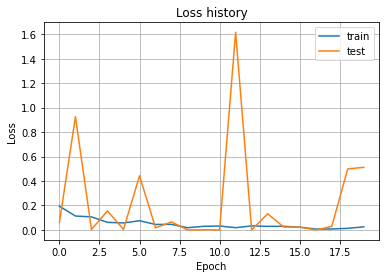

In [77]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();